In [1]:
### imporitng lib

In [3]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from causalnex.structure.notears import from_pandas
from causalnex.structure import StructureModel
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from sklearn.preprocessing import LabelEncoder

In [4]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))


In [ ]:
# data reading 

In [25]:
df_tripOrder = pd.read_csv("../data/newCleanData.csv")

In [9]:
df.shape

(1555718, 20)

In [26]:
colu = ['Unnamed: 0', 'Trip_Origin_lat','Trip_Origin_lng','Trip_Origin_lng', 'Trip_Destn_lat', 'Trip_Destn_lng', 'id', 'order_id','driver_id', 'lat', 'lng']

In [28]:
df_tripOrder.drop(colu, inplace = True, axis =1)

In [29]:
# the selected columns for causal graph
df_tripOrder.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,Distance,Speed,driver_action,is_weekend,is_holiday
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,accepted,0,0
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,rejected,0,0
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,rejected,0,0
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,rejected,0,0
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,rejected,0,0


In [ ]:
#df = pd.read_csv("../data/newCleanData.csv")

In [30]:
#df.info()

In [7]:
# sm.add_edges_from([
#     ('health', 'absences'),
#     ('health', 'G1')
# ])

In [40]:
# visualize the structure
#sm.edges

In [49]:

# viz = plot_structure(
#     sm,
#     graph_attributes={"scale": "0.5"},
#     all_node_attributes=NODE_STYLE.WEAK,
#     all_edge_attributes=EDGE_STYLE.WEAK,
# )
# Image(viz.draw(format='png'))

## preparing the data for learning 

In [50]:
df_tripOrder = pd.read_csv("../data/newCleanData.csv")

In [51]:
colu = ['Unnamed: 0', 'Trip_Origin_lat','Trip_Origin_lng','Trip_Origin_lng', 'Trip_Destn_lat', 'Trip_Destn_lng', 'id', 'order_id','driver_id', 'lat', 'lng']

In [52]:
df_tripOrder.drop(colu, inplace = True, axis =1)

In [53]:
df_tripOrder.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,Distance,Speed,driver_action,is_weekend,is_holiday
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,accepted,0,0
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,rejected,0,0
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,rejected,0,0
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,rejected,0,0
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,20.98,217.00,rejected,0,0


In [71]:
df_tripOrder.to_csv('../data/forCusalGraph.csv', index =False)

In [76]:
# copy the data
struct_data = df_tripOrder.copy()

**The data is resource intensive and random subdata would be used to construct the causal graph.**

In [77]:
struct_data.shape

(1555718, 10)

In [78]:
# identifying cattgorical variable
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time', 'driver_action']


In [79]:
# changing to numeric values 
le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])
struct_data.head(5)

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,Distance,Speed,driver_action,is_weekend,is_holiday
0,392001,11676,3785,275,123,20.98,217.00,0,0,0
1,392001,11676,3785,275,123,20.98,217.00,1,0,0
2,392001,11676,3785,275,123,20.98,217.00,1,0,0
3,392001,11676,3785,275,123,20.98,217.00,1,0,0
4,392001,11676,3785,275,123,20.98,217.00,1,0,0


In [80]:
# initializing the structural model
sm = StructureModel()
# applying notears algorithm
sm = from_pandas(struct_data.sample(50000))

**and visualise the learned StructureModel using the plot function.**

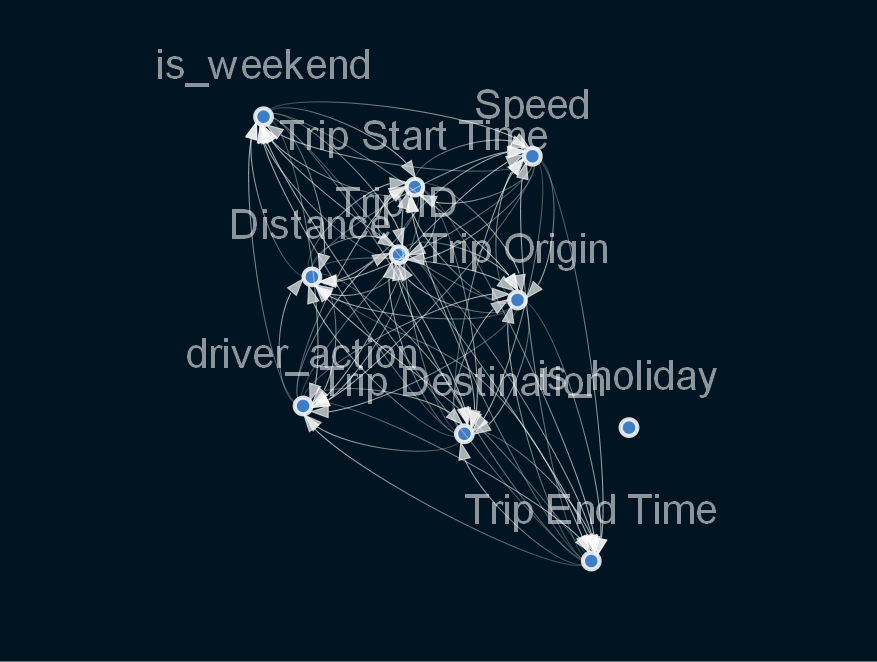

In [82]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

- The `Trip ID` is identical with `Order_id`(orders by the customers)

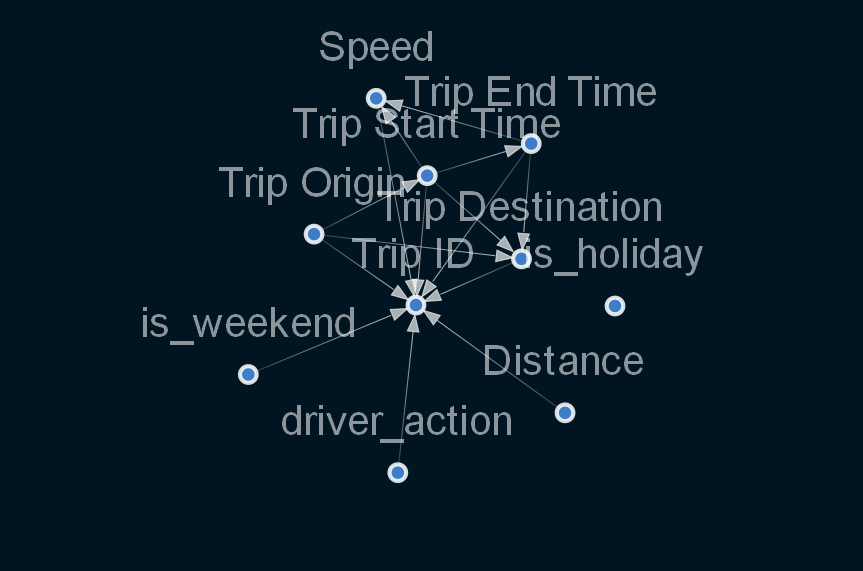

In [83]:
## removing edges with low threshold
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

in this structure, we can see that there are some relationships that appear intuitively correct:

- driver_action affects Trip ID/order_id - orders may be accpeted or rejected by the drivers.

- distance affects  Trip ID/order_id - the distance between the driver location and customer location may affect the fulfillment of orders. Sometimes if the distance is large, the order might rejected.

In [23]:
import networkx as nx

nx.drawing.nx_pydot.write_dot(sm, 'causalgraph.dot')

In [46]:
# removing 
sm.remove_edge('Trip Start Time', 'Trip End Time')
sm.remove_edge('Trip End Time','Trip Start Time')

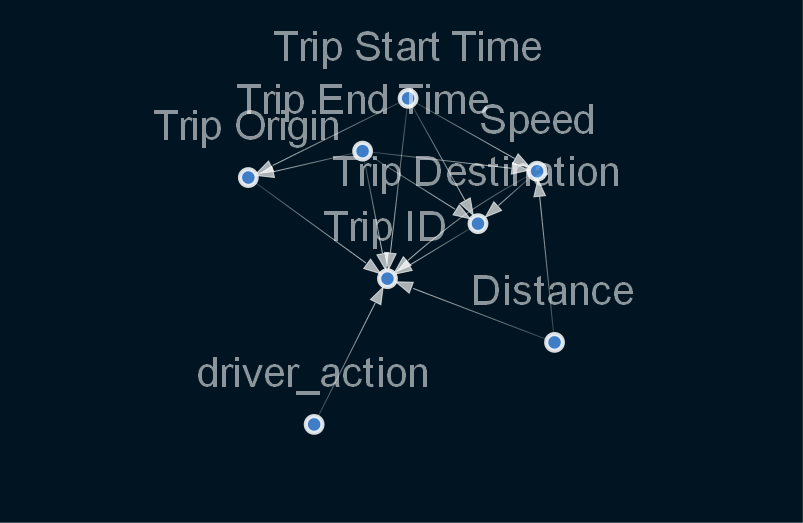

In [47]:
sm = sm.get_largest_subgraph()
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

## Fitting the Conditional Distribution of the Bayesian Network

In [48]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)